In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Lib.module.risk_budgeting import *
import student_mixture as sm
from tqdm import tqdm
from Lib.module.movidas import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
freq = 'B'
df_all = pd.concat([pd.read_excel('Data/SP_RC.xlsx',index_col=0, header=[0,1]), pd.read_excel('Data/SP_RC2.xlsx',index_col=0, header=[0,1])])
df_all = df_all.dropna(how='all').dropna(axis=1)
df_all = df_all.pct_change().dropna()
df_all = df_all.replace([np.inf, -np.inf], np.nan)
df_all = df_all[~df_all.index.duplicated(keep='first')]
first_level_index = df_all.columns.get_level_values(0)

In [25]:
d = 3
selected_indices = np.random.choice(range(len(first_level_index)), d, replace = False)
assets = first_level_index[selected_indices]
assets = ['JPM UN Equity', 'PFE UN Equity', 'XOM UN Equity']
nb_asset = len(assets)
df = df_all[assets]
X = df.values

### Fit Student-t mixture (2 components) to chosen stock returns
n_sm = 2
SM_model = sm.StudentMixture(n_components=n_sm, fixed_dofs = True, dofs_init = [2.5,4]).fit(X)

# ERC
budgets = np.ones(nb_asset)/nb_asset 
# Expected Shortfall alpha
alpha = .95 

SM_theta, optim_res = StudentMixtureExpectedShortfall(SM_model).solve_risk_budgeting(budgets, alpha, on_simplex=False, kappa=1, method=None, maxiter=15000)
VaR_port = StudentMixtureExpectedShortfall(SM_model).value_at_risk(SM_theta, alpha)
ES_port = StudentMixtureExpectedShortfall(SM_model).expected_shortfall(SM_theta, alpha)
risk_contribs = SM_theta * StudentMixtureExpectedShortfall(SM_model).expected_shortfall_gradient(SM_theta, alpha)

optimal_loss = StudentMixtureExpectedShortfall(SM_model).expected_shortfall(optim_res.x, alpha) - np.dot(budgets, np.log(optim_res.x))

n_val=1000000
X = SM_model.rvs(n_val)
np.random.shuffle(X)

gamma = 1

y_sgd = budgets / np.std(X, axis=0)
xi_sgd = 0
c_sgd = .65

y_smd = budgets / np.std(X, axis=0)
xi_smd = 0
c_smd = .65
M = 500

y_sgd_s = [y_sgd]
xi_sgd_s = [xi_sgd]


y_smd_s = [y_smd]
xi_smd_s = [xi_smd]

freq_y = 10000

for k in tqdm(range(1, n_val)):
    x = X[k]
    
    ### SGD
    # gradient
    step_size_sgd = gamma/k**c_sgd
    indicator_sgd = -np.dot(y_sgd, x) - xi_sgd >= 0
    grad_y_sgd = -x/(1-alpha)*indicator_sgd - budgets/y_sgd
    grad_xi_sgd = 1 - (1 / (1 - alpha)) * indicator_sgd

    #descent
    y_sgd = y_sgd - step_size_sgd*grad_y_sgd*min(min(y_sgd),1)
    y_sgd = np.where(y_sgd <= 0, 1e-04, y_sgd)
    xi_sgd = xi_sgd - step_size_sgd*grad_xi_sgd
    # y_bar_sgd_numerator += y_sgd*step_size_sgd
    # y_bar_sgd_denominator += step_size_sgd

    ### SMD
    # gradient
    step_size_smd = gamma/k**c_smd
    indicator_smd = -np.dot(y_smd, x) - xi_smd >= 0
    grad_y_smd = -x/(1-alpha)*indicator_smd - budgets/y_smd
    grad_xi_smd = 1 - (1 / (1 - alpha)) * indicator_smd

    y_smd_min = min(min(y_smd),1)
    y_smd = y_smd*np.exp(-step_size_smd*y_smd_min*grad_y_smd)
    xi_smd = xi_smd - step_size_smd*grad_xi_smd
    sum_y_smd = np.sum(y_smd)
    if sum_y_smd>M:
        y_smd = M/sum_y_smd*y_smd

    if k%freq_y==0:
        y_sgd_s.append(y_sgd)
        xi_sgd_s.append(xi_sgd)
        y_smd_s.append(y_smd)
        xi_smd_s.append(xi_smd)



100%|██████████| 999999/999999 [00:28<00:00, 34487.45it/s]


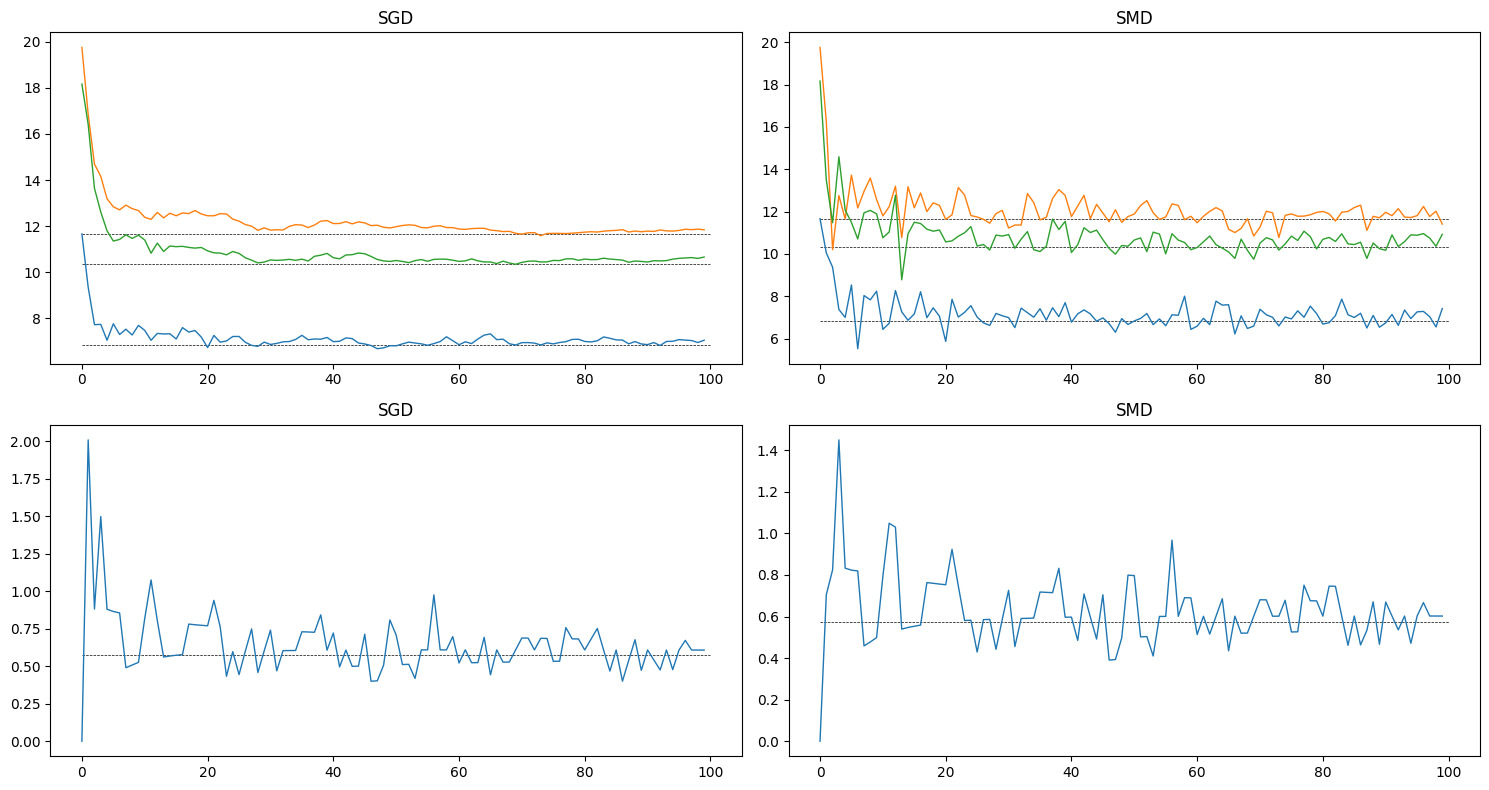

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax[0][0].plot(y_sgd_s, lw=1)
ax[0][0].set_title('SGD')
ax[0][1].plot(y_smd_s, lw=1)
ax[0][1].set_title('SMD')
ax[0][0].hlines(optim_res.x, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
ax[0][1].hlines(optim_res.x, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
# ax[0].set_ylim(0, 100) 
# ax[1].set_ylim(0, 20) 

ax[1][0].plot(xi_sgd_s, lw=1)
ax[1][0].set_title('SGD')
ax[1][1].plot(xi_smd_s, lw=1)
ax[1][1].set_title('SMD')
ax[1][0].hlines(VaR_port*sum(optim_res.x), 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
ax[1][1].hlines(VaR_port*sum(optim_res.x), 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
# ax[2].set_ylim(0, 100)
# ax[3].set_ylim(0, 20
plt.tight_layout()
plt.show()


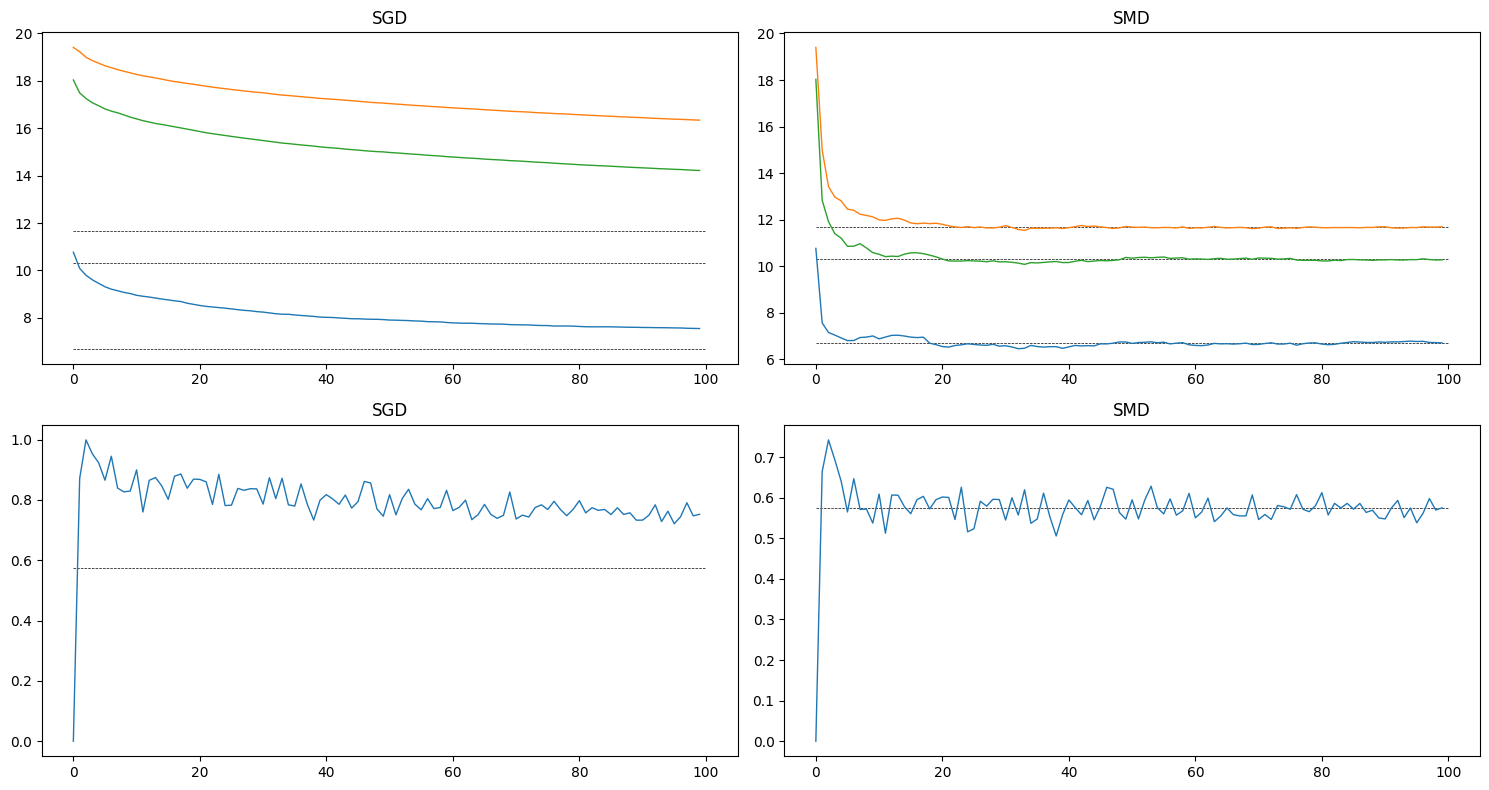

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax[0][0].plot(y_sgd_s, lw=1)
ax[0][0].set_title('SGD')
ax[0][1].plot(y_smd_s, lw=1)
ax[0][1].set_title('SMD')
ax[0][0].hlines(optim_res.x, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
ax[0][1].hlines(optim_res.x, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
# ax[0].set_ylim(0, 100) 
# ax[1].set_ylim(0, 20) 

ax[1][0].plot(xi_sgd_s, lw=1)
ax[1][0].set_title('SGD')
ax[1][1].plot(xi_smd_s, lw=1)
ax[1][1].set_title('SMD')
ax[1][0].hlines(VaR_port*sum(optim_res.x), 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
ax[1][1].hlines(VaR_port*sum(optim_res.x), 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
# ax[2].set_ylim(0, 100)
# ax[3].set_ylim(0, 20
plt.tight_layout()
plt.show()


Volatility

In [179]:
from scipy.optimize import minimize

gamma_vol_sgd = {10: 8.993581699307557, #bad
                25: 1.588949973074581, # ok
                50: 2.362259530234276,# good
                100: 5.400352947063323, #bad
                250: 0.6943142666952384}

gamma_vol_smd = {10: 17.67024667590496, #bad
 25: 3.3560192956492796, # ok
 50: 5.491985966810194, # bad
 100: 5.35791257359305, #ok
 250: 3.57894113149026}

def rb_vol(covariance_matrix, budgets):
    def objective(x):
        return (np.dot(x,np.dot(covariance_matrix, x)) - np.dot(budgets, np.log(x)))
    x0 = np.ones(len(budgets))
    bnds = [(1e-8,None) for _ in range(len(budgets))]
    res = minimize(objective, x0, bounds=bnds)
    return res.x, res.fun


d = 250
selected_indices = np.random.choice(range(len(first_level_index)), d, replace = False)
assets = first_level_index[selected_indices]
nb_asset = len(assets)
df = df_all[assets]
X = df.values

### Fit Student-t mixture (2 components) to chosen stock returns
n_sm = 1
SM_model = sm.StudentMixture(n_components=n_sm, fixed_dofs = True, dofs_init = [4]).fit(X)
SM_model.locations_ = np.array([np.zeros(nb_asset)])

# ERC
budgets = np.ones(nb_asset)/nb_asset 

y_ref, _ = rb_vol(SM_model.scales_[0], budgets)
SM_theta = y_ref/y_ref.sum()

n_val=500000
X = SM_model.rvs(n_val)
np.random.shuffle(X)

gamma_sgd = gamma_vol_sgd[d]
gamma_smd = gamma_vol_smd[d]

y_sgd = budgets / np.std(X, axis=0)
xi_sgd = 0
c_sgd = .55

y_smd = budgets / np.std(X, axis=0)
xi_smd = 0
c_smd = .55
M = 65

y_sgd_s = [y_sgd]
xi_sgd_s = [xi_sgd]


y_smd_s = [y_smd]
xi_smd_s = [xi_smd]

freq_y = 10000

for k in tqdm(range(1, n_val)):
    x = X[k]
    
    ### SGD
    # gradient
    step_size_sgd = gamma_sgd/k**c_sgd
    grad_y_sgd = 2 * (np.dot(y_sgd,x) - xi_sgd)*x - budgets/y_sgd
    grad_xi_sgd = -2 * (np.dot(y_sgd,x) - xi_sgd)

    #descent
    y_sgd = y_sgd - step_size_sgd*grad_y_sgd*min(min(y_sgd),1)
    y_sgd = np.where(y_sgd <= 0, 1e-04, y_sgd)
    xi_sgd = xi_sgd - step_size_sgd*grad_xi_sgd
    # y_bar_sgd_numerator += y_sgd*step_size_sgd
    # y_bar_sgd_denominator += step_size_sgd

    ### SMD
    # gradient
    step_size_smd = gamma_smd/k**c_smd
    grad_y_smd = 2 * (np.dot(y_smd,x) - xi_smd)*x - budgets/y_smd
    grad_xi_smd = -2 * (np.dot(y_smd,x) - xi_smd)

    y_smd_min = min(min(y_smd),1)
    y_smd = y_smd*np.exp(-step_size_smd*y_smd_min*grad_y_smd)
    xi_smd = xi_smd - step_size_smd*grad_xi_smd
    sum_y_smd = np.sum(y_smd)
    if sum_y_smd>M:
        y_smd = M/sum_y_smd*y_smd

    if k%freq_y==0:
        y_sgd_s.append(y_sgd)
        xi_sgd_s.append(xi_sgd)
        y_smd_s.append(y_smd)
        xi_smd_s.append(xi_smd)

100%|██████████| 499999/499999 [00:29<00:00, 17131.07it/s]


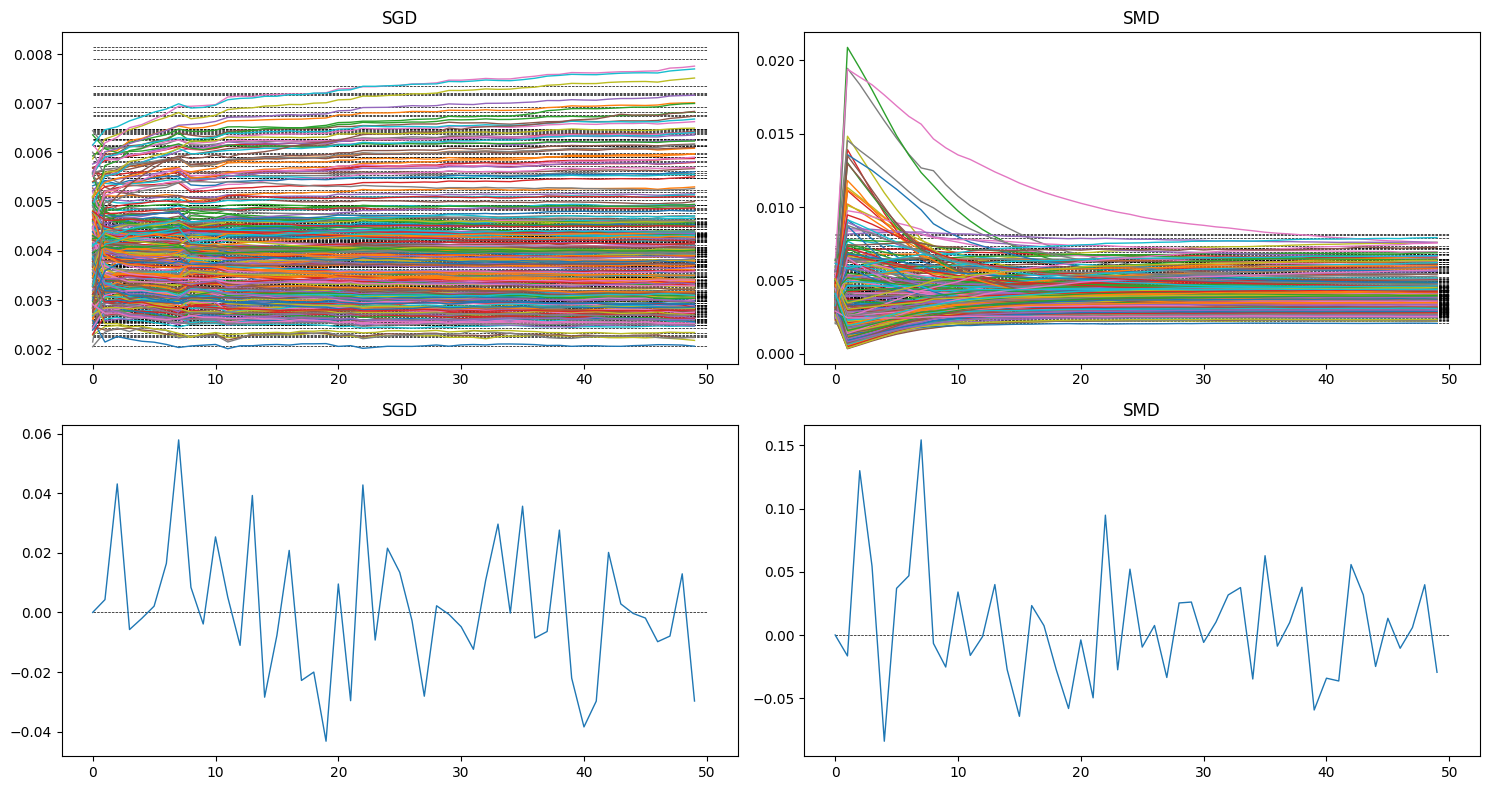

In [180]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax[0][0].plot((np.array(y_sgd_s)/np.array(y_sgd_s).sum(axis=1)[:,None])[:], lw=1)
ax[0][0].set_title('SGD')
ax[0][1].plot((np.array(y_smd_s)/np.array(y_smd_s).sum(axis=1)[:,None])[:], lw=1)
ax[0][1].set_title('SMD')
ax[0][0].hlines(SM_theta, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
ax[0][1].hlines(SM_theta, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
# ax[0].set_ylim(0, 100) 
# ax[1].set_ylim(0, 20) 

ax[1][0].plot(xi_sgd_s, lw=1)
ax[1][0].set_title('SGD')
ax[1][1].plot(xi_smd_s, lw=1)
ax[1][1].set_title('SMD')
ax[1][0].hlines(0, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
ax[1][1].hlines(0, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
# ax[2].set_ylim(0, 100)
# ax[3].set_ylim(0, 20)
plt.tight_layout()
plt.show()

In [93]:
sum(y_sgd)

51.9270566905195

Variantile

In [ ]:
from scipy.optimize import minimize

gamma_variantile = {10: 10, 25:12, 50:15, 100:18, 250:20}

def rb_vol(covariance_matrix, budgets):
    def objective(x):
        return (np.dot(x,np.dot(covariance_matrix, x)) - np.dot(budgets, np.log(x)))
    x0 = np.ones(len(budgets))
    bnds = [(1e-8,None) for _ in range(len(budgets))]
    res = minimize(objective, x0, bounds=bnds)
    return res.x, res.fun


d = 250
selected_indices = np.random.choice(range(len(first_level_index)), d, replace = False)
assets = first_level_index[selected_indices]
nb_asset = len(assets)
df = df_all[assets]
X = df.values

### Fit Student-t mixture (2 components) to chosen stock returns
n_sm = 1
SM_model = sm.StudentMixture(n_components=n_sm, fixed_dofs = True, dofs_init = [4]).fit(X)
SM_model.locations_ = np.array([np.zeros(nb_asset)])

# ERC
budgets = np.ones(nb_asset)/nb_asset 

y_ref, _ = rb_vol(SM_model.scales_[0], budgets)
SM_theta = y_ref/y_ref.sum()

n_val=1000000
X = SM_model.rvs(n_val)
np.random.shuffle(X)

alpha = .9

gamma = 20

y_sgd = budgets / np.std(X, axis=0)
xi_sgd = 0
c_sgd = .55

y_smd = budgets / np.std(X, axis=0)
xi_smd = 0
c_smd = .55
M = 1000

y_sgd_s = [y_sgd]
xi_sgd_s = [xi_sgd]


y_smd_s = [y_smd]
xi_smd_s = [xi_smd]

freq_y = 10000

for k in tqdm(range(1, n_val)):
    x = X[k]
    
    ### SGD
    # gradient
    step_size_sgd = gamma/k**c_sgd
    loss_sgd = -np.dot(y_sgd, x)
    indicator_pos_sgd = loss_sgd - xi_sgd >= 0
    indicator_neg_sgd = loss_sgd - xi_sgd < 0
    grad_y_sgd = -2 * alpha * (loss_sgd - xi_sgd) * x * indicator_pos_sgd + -2 * (1 - alpha) * (loss_sgd - xi_sgd) * x * indicator_neg_sgd - budgets/y_sgd
    grad_xi_sgd = -2 * alpha * (loss_sgd - xi_sgd) * indicator_pos_sgd + -2 * (1 - alpha) * (loss_sgd - xi_sgd) * indicator_neg_sgd

    #descent
    y_sgd = y_sgd - step_size_sgd*grad_y_sgd*min(min(y_sgd),1)
    y_sgd = np.where(y_sgd <= 0, 1e-04, y_sgd)
    xi_sgd = xi_sgd - step_size_sgd*grad_xi_sgd
    # y_bar_sgd_numerator += y_sgd*step_size_sgd
    # y_bar_sgd_denominator += step_size_sgd

    ### SMD
    # gradient
    step_size_smd = gamma/k**c_smd
    loss_smd = -np.dot(y_smd, x)
    indicator_pos_smd = loss_smd - xi_smd >= 0
    indicator_neg_smd = loss_smd - xi_smd < 0
    grad_y_smd = -2 * alpha * (loss_smd - xi_smd) * x * indicator_pos_smd + -2 * (1 - alpha) * (loss_smd - xi_smd) * x * indicator_neg_smd - budgets/y_smd
    grad_xi_smd = -2 * alpha * (loss_smd - xi_smd) * indicator_pos_smd + -2 * (1 - alpha) * (loss_smd - xi_smd) * indicator_neg_smd

    y_smd_min = min(min(y_smd),1)
    y_smd = y_smd*np.exp(-step_size_smd*y_smd_min*grad_y_smd)
    xi_smd = xi_smd - step_size_smd*grad_xi_smd
    sum_y_smd = np.sum(y_smd)
    if sum_y_smd>M:
        y_smd = M/sum_y_smd*y_smd

    if k%freq_y==0:
        y_sgd_s.append(y_sgd)
        xi_sgd_s.append(xi_sgd)
        y_smd_s.append(y_smd)
        xi_smd_s.append(xi_smd)

100%|██████████| 999999/999999 [01:03<00:00, 15753.21it/s]


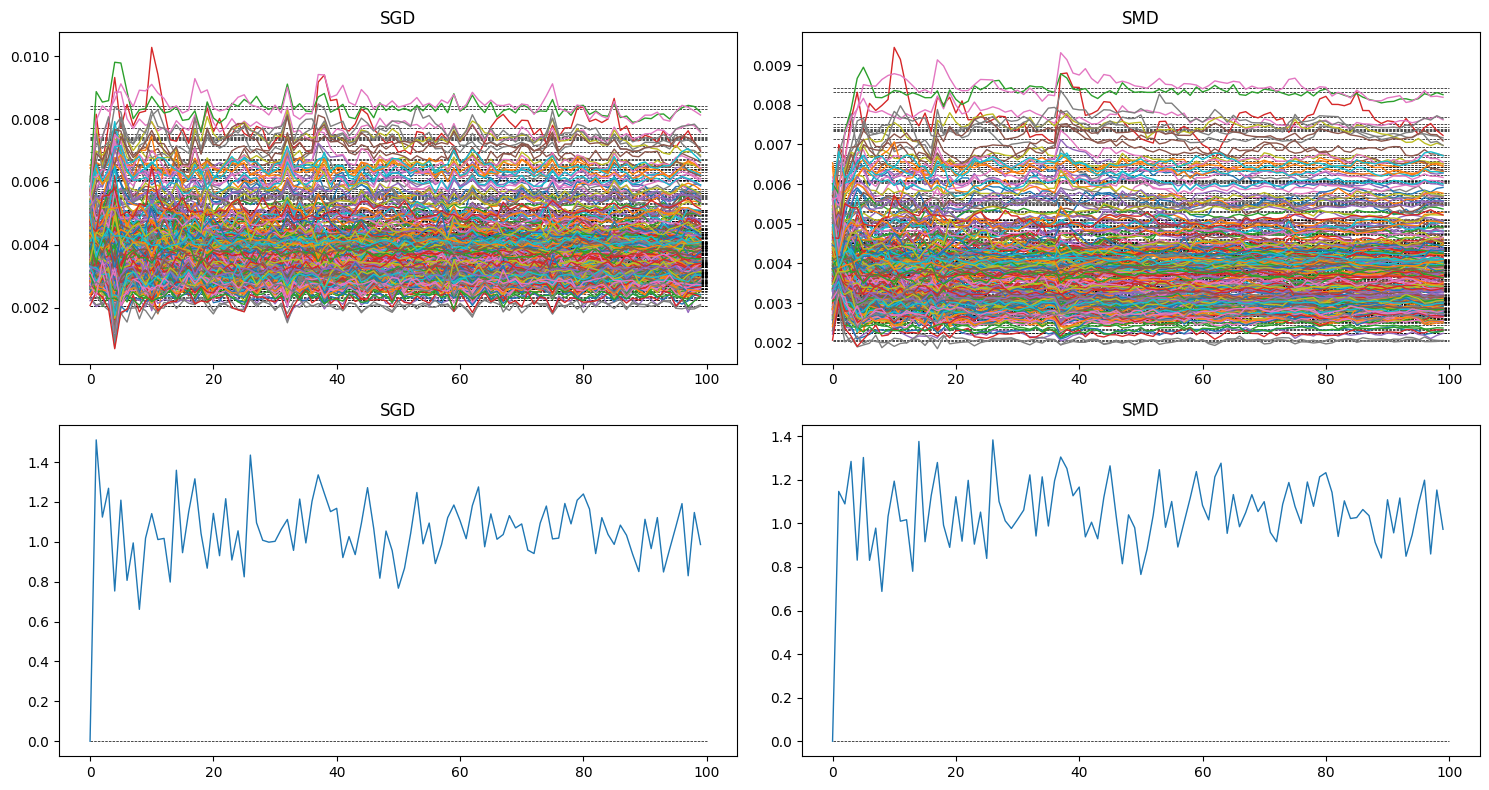

In [163]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax[0][0].plot(np.array(y_sgd_s)/np.array(y_sgd_s).sum(axis=1)[:,None], lw=1)
ax[0][0].set_title('SGD')
ax[0][1].plot(np.array(y_smd_s)/np.array(y_smd_s).sum(axis=1)[:,None], lw=1)
ax[0][1].set_title('SMD')
ax[0][0].hlines(SM_theta, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
ax[0][1].hlines(SM_theta, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
# ax[0].set_ylim(0, 100) 
# ax[1].set_ylim(0, 20) 

ax[1][0].plot(xi_sgd_s, lw=1)
ax[1][0].set_title('SGD')
ax[1][1].plot(xi_smd_s, lw=1)
ax[1][1].set_title('SMD')
ax[1][0].hlines(0, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
ax[1][1].hlines(0, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
# ax[2].set_ylim(0, 100)
# ax[3].set_ylim(0, 20)
plt.tight_layout()
plt.show()

In [164]:
sum(y_smd)

85.63222234970388

MAD

In [214]:
gamma_mad = {10: 25, 25:25, 50:12, 100:20, 250:25}

from scipy.optimize import minimize

def rb_vol(covariance_matrix, budgets):
    def objective(x):
        return (np.dot(x,np.dot(covariance_matrix, x)) - np.dot(budgets, np.log(x)))
    x0 = np.ones(len(budgets))
    bnds = [(1e-8,None) for _ in range(len(budgets))]
    res = minimize(objective, x0, bounds=bnds)
    return res.x, res.fun


d = 10
selected_indices = np.random.choice(range(len(first_level_index)), d, replace = False)
assets = first_level_index[selected_indices]
nb_asset = len(assets)
df = df_all[assets]
X = df.values

### Fit Student-t mixture (1 components) to chosen stock returns
n_sm = 1
SM_model = sm.StudentMixture(n_components=n_sm, fixed_dofs = True, dofs_init = [4]).fit(X)
SM_model.locations_ = np.array([np.zeros(nb_asset)])

# ERC
budgets = np.ones(nb_asset)/nb_asset 

y_ref, _ = rb_vol(SM_model.scales_[0], budgets)
SM_theta = y_ref/y_ref.sum()

n_val=1000000
X = SM_model.rvs(n_val)
np.random.shuffle(X)

gamma = 20

y_sgd = budgets / np.std(X, axis=0)
xi_sgd = 0
c_sgd = .65

y_smd = budgets / np.std(X, axis=0)
xi_smd = 0
c_smd = .65
M = 200

y_sgd_s = [y_sgd]
xi_sgd_s = [xi_sgd]


y_smd_s = [y_smd]
xi_smd_s = [xi_smd]

freq_y = 10000

for k in tqdm(range(1, n_val)):
    x = X[k]
    
    ### SGD
    # gradient
    step_size_sgd = gamma/k**c_sgd
    loss_sgd = -np.dot(y_sgd, x)
    indicator_pos_sgd = (loss_sgd - xi_sgd >= 0)*1
    indicator_neg_sgd = 1 - indicator_pos_sgd
    grad_y_sgd = (indicator_neg_sgd - indicator_pos_sgd)*x - budgets/y_sgd
    grad_xi_sgd = indicator_neg_sgd - indicator_pos_sgd

    #descent
    y_sgd = y_sgd - step_size_sgd*grad_y_sgd*min(min(y_sgd),1)
    y_sgd = np.where(y_sgd <= 0, 1e-04, y_sgd)
    xi_sgd = xi_sgd - step_size_sgd*grad_xi_sgd
    # y_bar_sgd_numerator += y_sgd*step_size_sgd
    # y_bar_sgd_denominator += step_size_sgd

    ### SMD
    # gradient
    step_size_smd = gamma/k**c_smd
    loss_smd = -np.dot(y_smd, x)
    indicator_pos_smd = (loss_smd - xi_smd >= 0)*1
    indicator_neg_smd = 1-indicator_pos_smd
    grad_y_smd = (indicator_neg_smd - indicator_pos_smd)*x - budgets/y_smd 
    grad_xi_smd = indicator_neg_smd - indicator_pos_smd

    y_smd_min = min(min(y_smd),1)
    y_smd = y_smd*np.exp(-step_size_smd*y_smd_min*grad_y_smd)
    xi_smd = xi_smd - step_size_smd*grad_xi_smd
    sum_y_smd = np.sum(y_smd)
    if sum_y_smd>M:
        y_smd = M/sum_y_smd*y_smd

    if k%freq_y==0:
        y_sgd_s.append(y_sgd)
        xi_sgd_s.append(xi_sgd)
        y_smd_s.append(y_smd)
        xi_smd_s.append(xi_smd)

100%|██████████| 999999/999999 [00:28<00:00, 34517.94it/s]


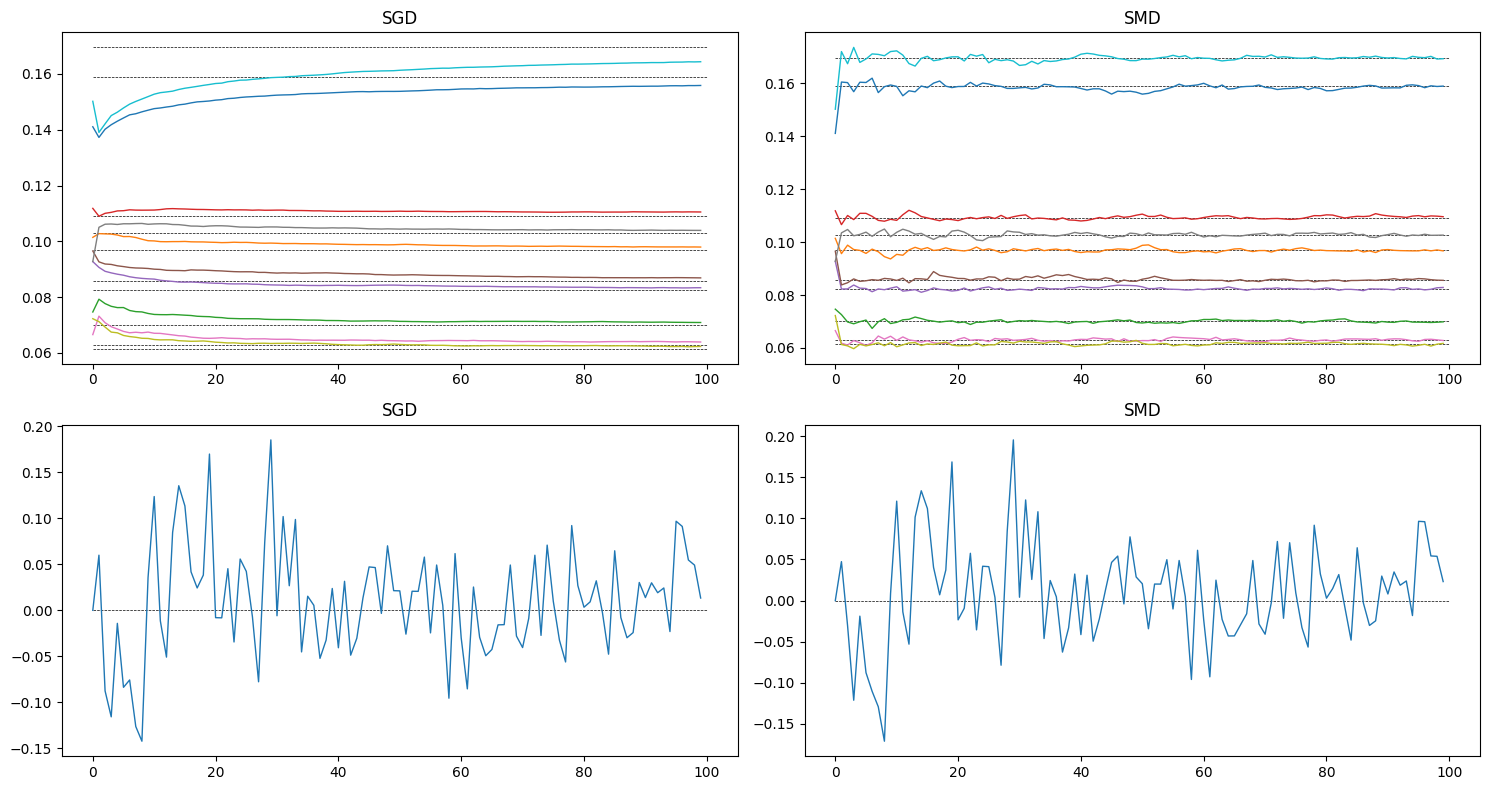

In [215]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax[0][0].plot(np.array(y_sgd_s)/np.array(y_sgd_s).sum(axis=1)[:,None], lw=1)
ax[0][0].set_title('SGD')
ax[0][1].plot(np.array(y_smd_s)/np.array(y_smd_s).sum(axis=1)[:,None], lw=1)
ax[0][1].set_title('SMD')
ax[0][0].hlines(SM_theta, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
ax[0][1].hlines(SM_theta, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
# ax[0].set_ylim(0, 100) 
# ax[1].set_ylim(0, 20) 

ax[1][0].plot(xi_sgd_s, lw=1)
ax[1][0].set_title('SGD')
ax[1][1].plot(xi_smd_s, lw=1)
ax[1][1].set_title('SMD')
ax[1][0].hlines(0, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
ax[1][1].hlines(0, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
# ax[2].set_ylim(0, 100)
# ax[3].set_ylim(0, 20)
plt.tight_layout()
plt.show()

In [211]:
from scipy.optimize import minimize

def rb_vol(covariance_matrix, budgets):
    def objective(x):
        return (np.dot(x,np.dot(covariance_matrix, x)) - np.dot(budgets, np.log(x)))
    x0 = np.ones(len(budgets))
    bnds = [(1e-8,None) for _ in range(len(budgets))]
    res = minimize(objective, x0, bounds=bnds)
    return res.x, res.fun

# gamma_tamed = {10:1, 25:.5, 50:.3, 100:2, 250:25}
np.random.seed(0)

d = 10
selected_indices = np.random.choice(range(len(first_level_index)), d, replace = False)
assets = first_level_index[selected_indices]
nb_asset = len(assets)
df = df_all[assets]
X = df.values

### Fit Student-t mixture (2 components) to chosen stock returns
n_sm = 2
SM_model = sm.StudentMixture(n_components=n_sm, fixed_dofs = True, dofs_init = [2.5,4]).fit(X)

# ERC
budgets = np.ones(nb_asset)/nb_asset 

n_val=1000000
X = SM_model.rvs(n_val)
np.random.shuffle(X)

vcv = np.cov(X, rowvar=False)
optim_res, optimal_loss = rb_vol(vcv, budgets)
SM_theta = optim_res/optim_res.sum()

gamma = 2

y_sgd = budgets / np.std(X, axis=0)
xi_sgd = 0
c_sgd = .65

y_smd = budgets / np.std(X, axis=0)
xi_smd = 0
c_smd = .65
M = 100

y_sgd_s = [y_sgd]
xi_sgd_s = [xi_sgd]


y_smd_s = [y_smd]
xi_smd_s = [xi_smd]

freq_y = 10000

for k in tqdm(range(1, n_val)):
    x = X[k]
    
    ### SGD
    # gradient
    step_size_sgd = gamma/k**c_sgd
    grad_y_sgd = 2 * (np.dot(y_sgd,x) - xi_sgd)*x - budgets/y_sgd
    grad_xi_sgd = -2 * (np.dot(y_sgd,x) - xi_sgd)

    #descent
    y_sgd = y_sgd - step_size_sgd*grad_y_sgd*min(min(y_sgd),1)
    y_sgd = np.where(y_sgd <= 0, 1e-04, y_sgd)
    xi_sgd = xi_sgd - step_size_sgd*grad_xi_sgd
    # y_bar_sgd_numerator += y_sgd*step_size_sgd
    # y_bar_sgd_denominator += step_size_sgd

    ### SMD
    # gradient
    step_size_smd = gamma/k**c_smd
    grad_y_smd = 2 * (np.dot(y_smd,x) - xi_smd)*x - budgets/y_smd
    grad_xi_smd = -2 * (np.dot(y_smd,x) - xi_smd)

    y_smd_min = min(min(y_smd),1)
    y_smd = y_smd*np.exp(-step_size_smd*y_smd_min*grad_y_smd)
    xi_smd = xi_smd - step_size_smd*grad_xi_smd
    sum_y_smd = np.sum(y_smd)
    if sum_y_smd>M:
        y_smd = M/sum_y_smd*y_smd

    if k%freq_y==0:
        y_sgd_s.append(y_sgd)
        xi_sgd_s.append(xi_sgd)
        y_smd_s.append(y_smd)
        xi_smd_s.append(xi_smd)



100%|██████████| 999999/999999 [00:25<00:00, 39033.74it/s]


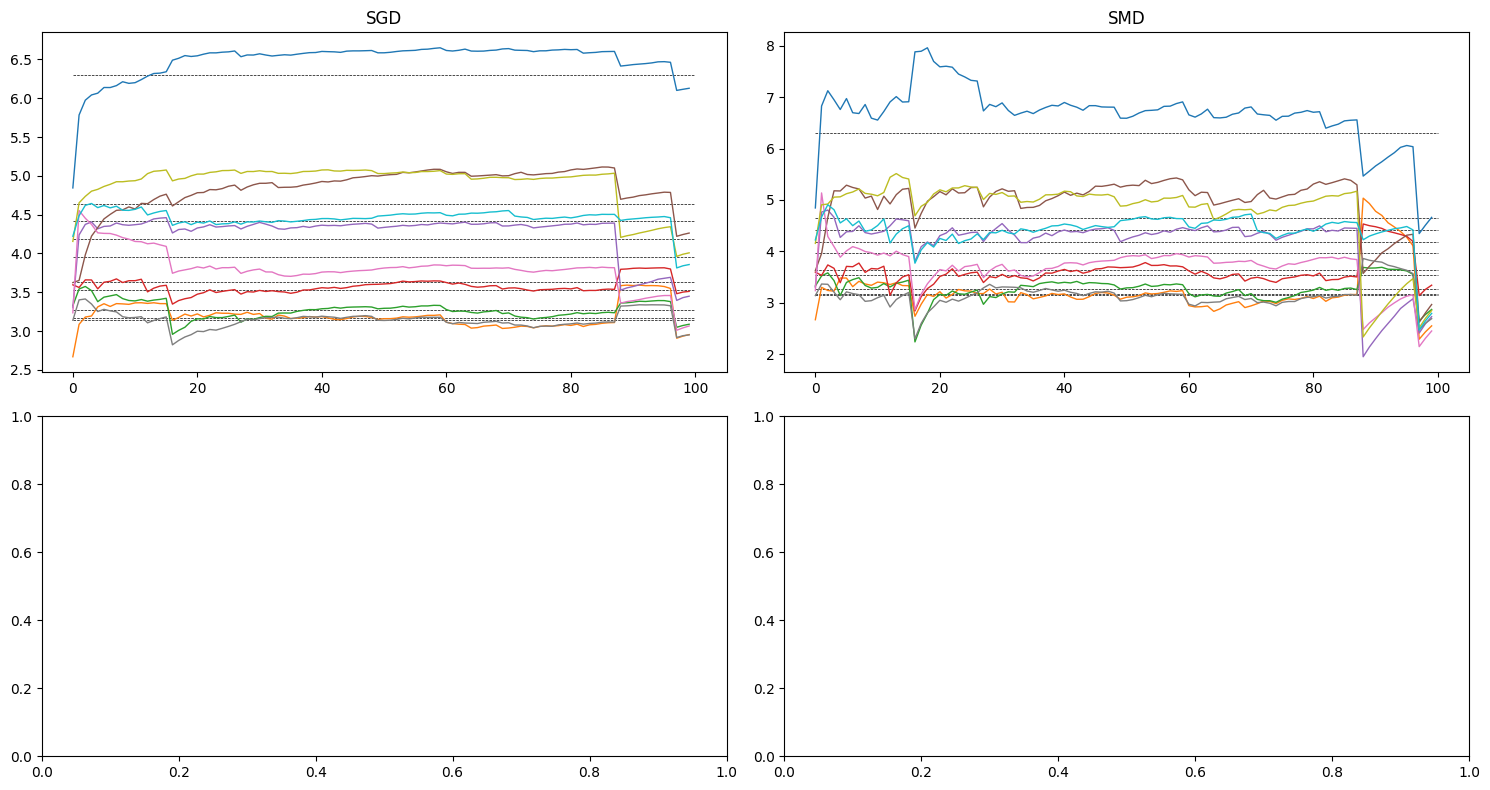

In [136]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax[0][0].plot(y_sgd_s, lw=1)
ax[0][0].set_title('SGD')
ax[0][1].plot(y_smd_s, lw=1)
ax[0][1].set_title('SMD')
ax[0][0].hlines(optim_res, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
ax[0][1].hlines(optim_res, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
# ax[0].set_ylim(0, 100) 
# ax[1].set_ylim(0, 20) 

# ax[1][0].plot(xi_sgd_s, lw=1)
# ax[1][0].set_title('SGD')
# ax[1][1].plot(xi_smd_s, lw=1)
# ax[1][1].set_title('SMD')
# ax[1][0].hlines(VaR_port*sum(optim_res), 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
# ax[1][1].hlines(VaR_port*sum(optim_res), 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
# ax[2].set_ylim(0, 100)
# ax[3].set_ylim(0, 20)
plt.tight_layout()
plt.show()

MAD

Variantile

In [9]:
# gamma_tamed = {10:.75, 25:.5, 50:.3, 100:2, 250:25}

d = 10
alpha = .9
gamma = 1
# ERC
budgets = np.ones(nb_asset)/nb_asset 

selected_indices = np.random.choice(range(len(first_level_index)), d, replace = False)
assets = first_level_index[selected_indices]
nb_asset = len(assets)
df = df_all[assets]
X = df.values

### Fit Student-t mixture (2 components) to chosen stock returns
n_sm = 2
SM_model = sm.StudentMixture(n_components=n_sm, fixed_dofs = True, dofs_init = [2.5,4]).fit(X)


### reference portfolio
y_ref = 0
polyak_ruppert = .2
n_ref = 1000000
X = SM_model.rvs(n_ref)
np.random.shuffle(X)
y_smd = budgets / np.std(X, axis=0)
xi_smd = 0
c_smd = .65
M = 100
n_epoch = 2
j = 1
for _ in tqdm(range(n_epoch)):
    np.random.shuffle(X)   
    for k in range(1, n_ref):
        x = X[k]
        step_size_smd = gamma/j**c_smd
        loss_smd = -np.dot(y_smd, x)
        indicator_pos_smd = loss_smd - xi_smd >= 0
        indicator_neg_smd = loss_smd - xi_smd < 0
        grad_y_smd = -2 * alpha * (loss_smd - xi_smd) * x * indicator_pos_smd + -2 * (1 - alpha) * (loss_smd - xi_smd) * x * indicator_neg_smd - budgets/y_smd
        grad_xi_smd = -2 * alpha * (loss_smd - xi_smd) * indicator_pos_smd + -2 * (1 - alpha) * (loss_smd - xi_smd) * indicator_neg_smd

        y_smd_min = min(min(y_smd),1)
        y_smd = y_smd*np.exp(-step_size_smd*y_smd_min*grad_y_smd)
        xi_smd = xi_smd - step_size_smd*grad_xi_smd
        sum_y_smd = np.sum(y_smd)
        if sum_y_smd>M:
            y_smd = M/sum_y_smd*y_smd   
        if j>int((1-polyak_ruppert)*n_ref*n_epoch):
            y_ref += y_smd
            j += 1
y_ref = y_ref/(j-1)
SM_theta = y_ref/np.sum(y_ref)


n_val=1000000
X = SM_model.rvs(n_val)
np.random.shuffle(X)

y_sgd = budgets / np.std(X, axis=0)
xi_sgd = 0
c_sgd = .65

y_smd = budgets / np.std(X, axis=0)
xi_smd = 0
c_smd = .65
M = 100

y_sgd_s = [y_sgd]
xi_sgd_s = [xi_sgd]


y_smd_s = [y_smd]
xi_smd_s = [xi_smd]

freq_y = 10000

for k in tqdm(range(1, n_val)):
    x = X[k]
    
    ### SGD
    # gradient

                    # loss = -np.dot(y, x.T)
                    # indicator_pos = (loss - t >= 0).reshape((x.shape[0], 1))
                    # indicator_neg = (loss - t < 0).reshape((x.shape[0], 1))
                    # grad_t = np.mean(
                    #     self.beta * -2 * self.alpha * (loss - t) * indicator_pos + -2 * (1 - self.alpha) * (
                    #             loss - t) * indicator_neg)
                    # grad_y = np.mean(self.beta *
                    #                  -2 * self.alpha * (loss - t).reshape((x.shape[0], 1)) * x * indicator_pos + -2 * (
                    #                          1 - self.alpha) * (loss - t).reshape(
                    #     (x.shape[0], 1)) * x * indicator_neg - self.budgets / y, axis=0)
    
    step_size_sgd = gamma/k**c_sgd
    loss_sgd = -np.dot(y_sgd, x)
    indicator_pos_sgd = loss_sgd - xi_sgd >= 0
    indicator_neg_sgd = loss_sgd - xi_sgd < 0
    grad_y_sgd = -2 * alpha * (loss_sgd - xi_sgd) * x * indicator_pos_sgd + -2 * (1 - alpha) * (loss_sgd - xi_sgd) * x * indicator_neg_sgd - budgets/y_sgd
    grad_xi_sgd = -2 * alpha * (loss_sgd - xi_sgd) * indicator_pos_sgd + -2 * (1 - alpha) * (loss_sgd - xi_sgd) * indicator_neg_sgd

    #descent
    y_sgd = y_sgd - step_size_sgd*grad_y_sgd*min(min(y_sgd),1)
    y_sgd = np.where(y_sgd <= 0, 1e-04, y_sgd)
    xi_sgd = xi_sgd - step_size_sgd*grad_xi_sgd
    # y_bar_sgd_numerator += y_sgd*step_size_sgd
    # y_bar_sgd_denominator += step_size_sgd

    ### SMD
    # gradient
    step_size_smd = gamma/k**c_smd
    loss_smd = -np.dot(y_smd, x)
    indicator_pos_smd = loss_smd - xi_smd >= 0
    indicator_neg_smd = loss_smd - xi_smd < 0
    grad_y_smd = -2 * alpha * (loss_smd - xi_smd) * x * indicator_pos_smd + -2 * (1 - alpha) * (loss_smd - xi_smd) * x * indicator_neg_smd - budgets/y_smd
    grad_xi_smd = -2 * alpha * (loss_smd - xi_smd) * indicator_pos_smd + -2 * (1 - alpha) * (loss_smd - xi_smd) * indicator_neg_smd

    y_smd_min = min(min(y_smd),1)
    y_smd = y_smd*np.exp(-step_size_smd*y_smd_min*grad_y_smd)
    xi_smd = xi_smd - step_size_smd*grad_xi_smd
    sum_y_smd = np.sum(y_smd)
    if sum_y_smd>M:
        y_smd = M/sum_y_smd*y_smd

    if k%freq_y==0:
        y_sgd_s.append(y_sgd)
        xi_sgd_s.append(xi_sgd)
        y_smd_s.append(y_smd)
        xi_smd_s.append(xi_smd)



100%|██████████| 2/2 [01:01<00:00, 30.53s/it]


ZeroDivisionError: division by zero

In [8]:
j

1

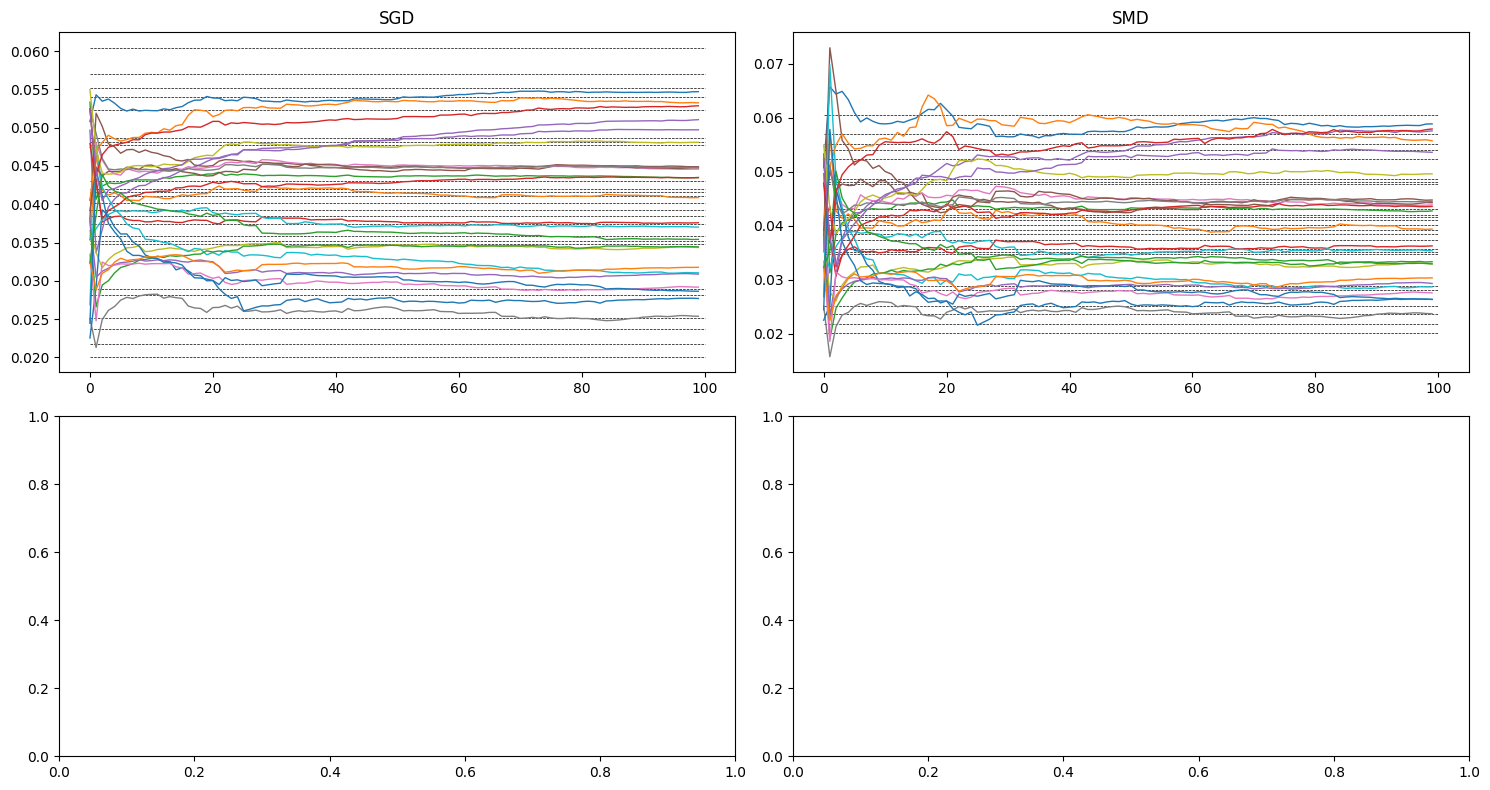

In [182]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax[0][0].plot(np.array(y_sgd_s)/np.array(y_sgd_s).sum(axis=1)[:,None], lw=1)
ax[0][0].set_title('SGD')
ax[0][1].plot(np.array(y_smd_s)/np.array(y_smd_s).sum(axis=1)[:,None], lw=1)
ax[0][1].set_title('SMD')
ax[0][0].hlines(SM_theta, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
ax[0][1].hlines(SM_theta, 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
# ax[0].set_ylim(0, 100) 
# ax[1].set_ylim(0, 20) 

# ax[1][0].plot(xi_sgd_s, lw=1)
# ax[1][0].set_title('SGD')
# ax[1][1].plot(xi_smd_s, lw=1)
# ax[1][1].set_title('SMD')
# ax[1][0].hlines(VaR_port*sum(optim_res), 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
# ax[1][1].hlines(VaR_port*sum(optim_res), 0, len(y_sgd_s), colors='black', linestyles='dashed', lw=.5, zorder=0)
# ax[2].set_ylim(0, 100)
# ax[3].set_ylim(0, 20)
plt.tight_layout()
plt.show()

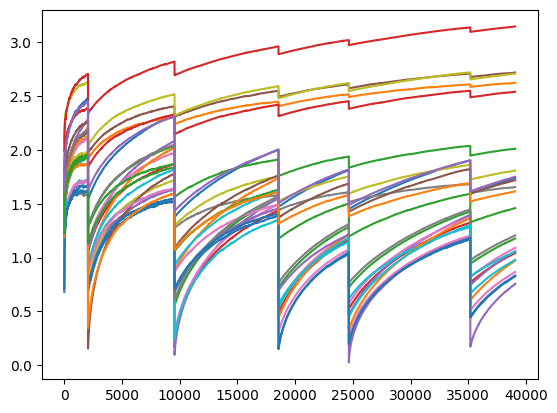

In [ ]:
plt.plot(rb.ys);

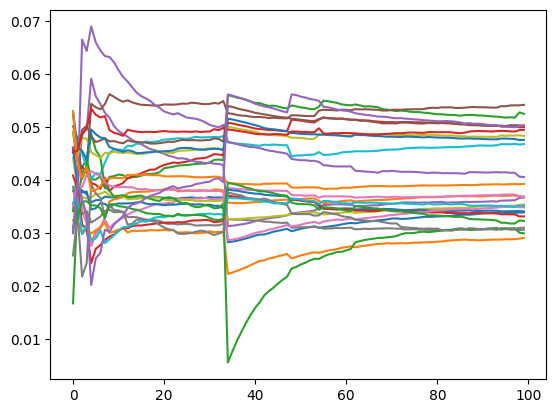

In [179]:
plt.plot(np.array(y_sgd_s)/np.array(y_sgd_s).sum(axis=1)[:,None])

In [165]:
y_smd_s[-1]/y_smd_s[-1].sum()

array([0.03436151, 0.03650372, 0.05524621, 0.05101207, 0.0372502 ,
       0.05764525, 0.03605166, 0.02974357, 0.03590321, 0.04852165,
       0.03285054, 0.02918295, 0.02943271, 0.03147521, 0.03681342,
       0.05045243, 0.03535343, 0.03017348, 0.0491022 , 0.03433083,
       0.04709076, 0.03907779, 0.03036565, 0.05107617, 0.05098337])

In [176]:
%%time
rb = RiskBudgeting(risk_measure='variantile',
                   alpha=0.9,
                   budgets='ERC')

rb.solve(SM_model.rvs(2000000), epochs=5)
rb.x

CPU times: total: 39.7 s
Wall time: 36 s


array([0.0354673 , 0.03834425, 0.049359  , 0.04802822, 0.03775399,
       0.05445657, 0.03710837, 0.02920425, 0.03548968, 0.04990095,
       0.03361524, 0.02924606, 0.03381557, 0.03190834, 0.04023153,
       0.04946632, 0.03866623, 0.0284463 , 0.04897549, 0.03470373,
       0.04751382, 0.04137148, 0.02979265, 0.0511925 , 0.04594218])

In [ ]:
rb.

AttributeError: 'RiskBudgeting' object has no attribute 'epochs'

In [146]:
y_smd_s[-1]/y_smd_s[-1].sum()

array([0.15260811, 0.09989393, 0.11210913, 0.14820106, 0.07669528,
       0.07747898, 0.0713693 , 0.10674103, 0.07533996, 0.07956321])

In [137]:
SM_theta

array([0.15641687, 0.07871302, 0.08130677, 0.09026644, 0.09835644,
       0.11525188, 0.08779208, 0.07820055, 0.10983053, 0.10386543])

In [98]:
SM_theta*(vcv@SM_theta)

array([2.45349975e-05, 2.45355306e-05, 2.45358966e-05, 2.45358587e-05,
       2.45348331e-05, 2.45358675e-05, 2.45347622e-05, 2.45357940e-05,
       2.45348978e-05, 2.45375572e-05])

In [66]:
budgets

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01])

In [75]:
StudentMixtureExpectedShortfall(SM_model).expected_shortfall(y_sgd, alpha) - np.dot(budgets, np.log(y_sgd)) - optimal_loss

1.0478230163290612

In [81]:
StudentMixtureExpectedShortfall(SM_model).expected_shortfall(y_smd, alpha) - np.dot(budgets, np.log(y_smd)) - optimal_loss

0.00017491870544095178

In [82]:
np.mean(abs(SM_theta-y_sgd/y_sgd.sum()))

0.000152000569585123

In [83]:
np.mean(abs(SM_theta-y_smd/y_smd.sum()))

9.213695317880166e-05

In [ ]:
for d in [10,25,50,100,250]:

    errors_sgd = []
    errors_smd = []

    norms_sgd = []
    norms_smd = []

    for i in range(100):
        selected_indices = np.random.choice(range(len(first_level_index)), d, replace = False)
        assets = first_level_index[selected_indices]
        nb_asset = len(assets)
        df = df_all[assets]
        X = df.values

        ### Fit Student-t mixture (2 components) to chosen stock returns
        n_sm = 2
        SM_model = sm.StudentMixture(n_components=n_sm, fixed_dofs = True, dofs_init = [2.5,4]).fit(X)

        # ERC
        budgets = np.ones(nb_asset)/nb_asset 
        # Expected Shortfall alpha
        alpha = .95 

        SM_theta, optim_res = StudentMixtureExpectedShortfall(SM_model).solve_risk_budgeting(budgets, alpha, on_simplex=False, kappa=1, method=None, maxiter=15000)
        VaR_port = StudentMixtureExpectedShortfall(SM_model).value_at_risk(SM_theta, alpha)
        ES_port = StudentMixtureExpectedShortfall(SM_model).expected_shortfall(SM_theta, alpha)
        risk_contribs = SM_theta * StudentMixtureExpectedShortfall(SM_model).expected_shortfall_gradient(SM_theta, alpha)

        optimal_loss = StudentMixtureExpectedShortfall(SM_model).expected_shortfall(optim_res.x, alpha) - np.dot(budgets, np.log(optim_res.x))

        n_val=1000000
        X = SM_model.rvs(n_val)
        np.random.shuffle(X)

        gamma = 10

        y_sgd = budgets / np.std(X, axis=0)
        xi_sgd = 0
        c_sgd = .65

        y_smd = budgets / np.std(X, axis=0)
        xi_smd = 0
        c_smd = .8
        M = 500

        y_sgd_s = [y_sgd]
        xi_sgd_s = [xi_sgd]
        y_bar_sgd_s = [y_sgd]
        y_bar_sgd_numerator = 0
        y_bar_sgd_denominator = 0

        y_smd_s = [y_smd]
        xi_smd_s = [xi_smd]
        y_bar_smd_s = [y_smd]
        y_bar_smd_numerator = 0
        y_bar_smd_denominator = 0

        error_sgd = []
        error_smd = []

        norm_sgd = []
        norm_smd = []

        freq_error = 100000

        for k in range(1, n_val):
            x = X[k]
            
            ### SGD
            # gradient
            step_size_sgd = gamma/k**c_sgd
            indicator_sgd = -np.dot(y_sgd, x) - xi_sgd >= 0
            grad_y_sgd = -x/(1-alpha)*indicator_sgd - budgets/y_sgd
            grad_xi_sgd = 1 - (1 / (1 - alpha)) * indicator_sgd

            #descent
            y_sgd = y_sgd - step_size_sgd*grad_y_sgd
            y_sgd = np.where(y_sgd <= 0, 1e-04, y_sgd)
            xi_sgd = xi_sgd - step_size_sgd*grad_xi_sgd
            y_bar_sgd_numerator += y_sgd*step_size_sgd
            y_bar_sgd_denominator += step_size_sgd

            ### SMD
            # gradient
            step_size_smd = gamma/k**c_smd
            indicator_smd = -np.dot(y_smd, x) - xi_smd >= 0
            grad_y_smd = -x/(1-alpha)*indicator_smd - budgets/y_smd
            grad_xi_smd = 1 - (1 / (1 - alpha)) * indicator_smd

            y_smd_min = min(min(y_smd),1)
            y_smd = y_smd*np.exp(-step_size_smd*y_smd_min*grad_y_smd)
            xi_smd = xi_smd - step_size_smd*grad_xi_smd
            sum_y_smd = np.sum(y_smd)
            if sum_y_smd>M:
                y_smd = M/sum_y_smd*y_smd
            y_bar_smd_numerator += y_smd*step_size_smd
            y_bar_smd_denominator += step_size_smd

            # y_sgd_s.append(y_sgd)
            # xi_sgd_s.append(xi_sgd)
            # y_bar_sgd_s.append(y_bar_sgd_numerator/y_bar_sgd_denominator)

            # y_smd_s.append(y_smd)
            # xi_smd_s.append(xi_smd)
            # y_bar_smd_s.append(y_bar_smd_numerator/y_bar_smd_denominator)

            if k%freq_error==0:
                error_sgd.append(StudentMixtureExpectedShortfall(SM_model).expected_shortfall(y_sgd, alpha) - np.dot(budgets, np.log(y_sgd)) - optimal_loss)
                error_smd.append(StudentMixtureExpectedShortfall(SM_model).expected_shortfall(y_smd, alpha) - np.dot(budgets, np.log(y_smd)) - optimal_loss)

                norm_sgd.append(np.mean(SM_theta-y_sgd/y_sgd.sum()))
                norm_smd.append(np.mean(SM_theta-y_smd/y_smd.sum()))

        errors_sgd.append(error_sgd)
        errors_smd.append(error_smd)

        norms_sgd.append(norm_sgd)
        norms_smd.append(norm_smd)
        np.save(str(d)+'_sgd_errors.npy', np.array(errors_sgd))
        np.save(str(d)+'_smd_errors.npy', np.array(errors_smd))     


In [6]:
### Import stock price data for model calibration
freq = 'B'
assets = ['JPM UN Equity', 'PFE UN Equity', 'XOM UN Equity']
nb_asset = len(assets)

df_all = pd.concat([pd.read_excel('Data/SP_RC.xlsx',index_col=0, header=[0,1]), pd.read_excel('Data/SP_RC2.xlsx',index_col=0, header=[0,1])])
df_all = df_all.dropna(how='all').dropna(axis=1)
df_all = df_all.pct_change().dropna()
df_all = df_all.replace([np.inf, -np.inf], np.nan)
df_all = df_all[~df_all.index.duplicated(keep='first')]
df = df_all[assets]

X = df.values
print(X.shape)

(3446, 3)


In [ ]:
selected_indices = np.random.choice(range(len(first_level_index)), 50, replace = False)
assets = first_level_index[selected_indices]
nb_asset = len(assets)
df = df_all[assets]
X = df.values


In [7]:
### Fit Student-t mixture (2 components) to chosen stock returns
n_sm = 2
SM_model = sm.StudentMixture(n_components=n_sm, fixed_dofs = True, dofs_init = [2.5,4]).fit(X)

In [8]:
### Print model parameters 
print("==== Number of assets ====")
print(nb_asset)
print("==== Number of mixture components ====")
print(n_sm)
print("==== Weights (probability) parameters ====")
print(SM_model.weights_)
print("==== Degree of freedom parameters ====")
print(SM_model.dofs_)
print("==== Location parameters ====")
print(SM_model.locations_)
print("==== Scale parameters ====")
print(SM_model.scales_)

==== Number of assets ====
3
==== Number of mixture components ====
2
==== Weights (probability) parameters ====
[0.57536895 0.42463105]
==== Degree of freedom parameters ====
[2.5 4. ]
==== Location parameters ====
[[-0.00070383 -0.00097538 -0.00182552]
 [ 0.00160405  0.00209373  0.00204925]]
==== Scale parameters ====
[[[2.45546634e-04 7.09484995e-05 8.74424168e-05]
  [7.09484995e-05 6.90364583e-05 4.56142046e-05]
  [8.74424168e-05 4.56142046e-05 1.04945729e-04]]

 [[9.06453859e-05 1.79115311e-05 4.41578466e-05]
  [1.79115311e-05 1.24689694e-04 1.80013614e-05]
  [4.41578466e-05 1.80013614e-05 1.06182789e-04]]]


In [9]:
### Compute the Risk Budgeting portfolio under the above model

# ERC
budgets = np.ones(nb_asset)/nb_asset 
# Expected Shortfall alpha
alpha = .95 

SM_theta, optim_res = StudentMixtureExpectedShortfall(SM_model).solve_risk_budgeting(budgets, alpha, on_simplex=False, kappa=1, method=None, maxiter=15000)
VaR_port = StudentMixtureExpectedShortfall(SM_model).value_at_risk(SM_theta, alpha)
ES_port = StudentMixtureExpectedShortfall(SM_model).expected_shortfall(SM_theta, alpha)
risk_contribs = SM_theta * StudentMixtureExpectedShortfall(SM_model).expected_shortfall_gradient(SM_theta, alpha)

print('==== Target Risk Bugdets ====')
print(np.round(budgets, 4))
print('==== $y^*$ ====')
print(np.round(optim_res.x, 4))

print('==== Risk Budgeting portfolio ($u^*$) ====')
print(np.round(SM_theta, 4))
print('==== VaR of the portfolio ====')
print(np.round(VaR_port, 4))
print('==== Expected Shortfall of the portfolio ====')
print(np.round(ES_port, 4))
print('==== Risk Contributions ====')
print(np.round(risk_contribs, 5))
print('==== Risk Contributions (normalized) ====')
print(np.round(risk_contribs/sum(risk_contribs), 2))

==== Target Risk Bugdets ====
[0.3333 0.3333 0.3333]
==== $y^*$ ====
[ 6.9959 11.6543  9.8087]
==== Risk Budgeting portfolio ($u^*$) ====
[0.2458 0.4095 0.3447]
==== VaR of the portfolio ====
0.0202
==== Expected Shortfall of the portfolio ====
0.0351
==== Risk Contributions ====
[0.01171 0.01171 0.01171]
==== Risk Contributions (normalized) ====
[0.33 0.33 0.33]


In [10]:
StudentMixtureExpectedShortfall(SM_model).solve_risk_budgeting(budgets, alpha, on_simplex=False, kappa=1, method=None, maxiter=15000)

(array([0.24582584, 0.40951357, 0.34466059]),
   message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
   success: True
    status: 0
       fun: -1.2280854838694133
         x: [ 6.996e+00  1.165e+01  9.809e+00]
       nit: 13
       jac: [ 1.110e-07  2.220e-07  1.332e-07]
      nfev: 56
      njev: 14
  hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>)

In [46]:
optimal_loss = StudentMixtureExpectedShortfall(SM_model).expected_shortfall(optim_res.x, alpha) - np.dot(budgets, np.log(optim_res.x))
optimal_loss

-1.2280854838694133

### SMD vs. SGD - Error analysis

In [48]:
np.random.seed(0)

errors_sgd = []
errors_smd = []

for i in tqdm(range(100)):

    n_val=1000000
    X = SM_model.rvs(n_val)
    np.random.shuffle(X)

    alpha = .95
    gamma = 10

    y_sgd = budgets / np.std(X, axis=0)
    xi_sgd = 0
    c_sgd = .65

    y_smd = budgets / np.std(X, axis=0)
    xi_smd = 0
    c_smd = .8
    M = 500

    y_sgd_s = [y_sgd]
    xi_sgd_s = [xi_sgd]
    y_bar_sgd_s = [y_sgd]
    y_bar_sgd_numerator = 0
    y_bar_sgd_denominator = 0

    y_smd_s = [y_smd]
    xi_smd_s = [xi_smd]
    y_bar_smd_s = [y_smd]
    y_bar_smd_numerator = 0
    y_bar_smd_denominator = 0

    error_sgd = []
    error_smd = []

    freq_error = 50

    for k in range(1, n_val):
        x = X[k]
        
        ### SGD
        # gradient
        step_size_sgd = gamma/k**c_sgd
        indicator_sgd = -np.dot(y_sgd, x) - xi_sgd >= 0
        grad_y_sgd = -x/(1-alpha)*indicator_sgd - budgets/y_sgd
        grad_xi_sgd = 1 - (1 / (1 - alpha)) * indicator_sgd

        #descent
        y_sgd = y_sgd - step_size_sgd*grad_y_sgd
        y_sgd = np.where(y <= 0, 1e-04, y_sgd)
        xi_sgd = xi_sgd - step_size_sgd*grad_xi_sgd
        y_bar_sgd_numerator += y_sgd*step_size_sgd
        y_bar_sgd_denominator += step_size_sgd

        ### SMD
        # gradient
        step_size_smd = gamma/k**c_smd
        indicator_smd = -np.dot(y_smd, x) - xi_smd >= 0
        grad_y_smd = -x/(1-alpha)*indicator_smd - budgets/y_smd
        grad_xi_smd = 1 - (1 / (1 - alpha)) * indicator_smd

        y_smd_min = min(min(y_smd),1)
        y_smd = y_smd*np.exp(-step_size_smd*y_smd_min*grad_y_smd)
        xi_smd = xi_smd - step_size_smd*grad_xi_smd
        sum_y_smd = np.sum(y_smd)
        if sum_y_smd>M:
            y_smd = M/sum_y_smd*y_smd
        y_bar_smd_numerator += y_smd*step_size_smd
        y_bar_smd_denominator += step_size_smd

        # y_sgd_s.append(y_sgd)
        # xi_sgd_s.append(xi_sgd)
        # y_bar_sgd_s.append(y_bar_sgd_numerator/y_bar_sgd_denominator)

        # y_smd_s.append(y_smd)
        # xi_smd_s.append(xi_smd)
        # y_bar_smd_s.append(y_bar_smd_numerator/y_bar_smd_denominator)

        if k%freq_error==0:
            error_sgd.append(StudentMixtureExpectedShortfall(SM_model).expected_shortfall(y_sgd, alpha) - np.dot(budgets, np.log(y_sgd)) - optimal_loss)
            error_smd.append(StudentMixtureExpectedShortfall(SM_model).expected_shortfall(y_smd, alpha) - np.dot(budgets, np.log(y_smd)) - optimal_loss)
    
    errors_sgd.append(error_sgd)
    errors_smd.append(error_smd)

    np.save('sgd_errors.npy', np.array(errors_sgd))
    np.save('smd_errors.npy', np.array(errors_smd))

 29%|██▉       | 29/100 [1:36:57<5:11:47, 263.49s/it]C:\Users\arcetingoz\AppData\Local\Temp\ipykernel_1112\1483225849.py:82: RuntimeWarning: invalid value encountered in log
  error_sgd.append(StudentMixtureExpectedShortfall(SM_model).expected_shortfall(y_sgd, alpha) - np.dot(budgets, np.log(y_sgd)) - optimal_loss)
 97%|█████████▋| 97/100 [5:29:53<10:12, 204.05s/it]  


KeyboardInterrupt: 

In [40]:
errors_sgd = []
errors_smd = []
for i in tqdm(ns):
    errors_sgd.append(StudentMixtureExpectedShortfall(SM_model).expected_shortfall(y_sgd_s[i], alpha) - np.dot(budgets, np.log(y_sgd_s[i])) - optimal_loss)
    errors_smd.append(StudentMixtureExpectedShortfall(SM_model).expected_shortfall(y_smd_s[i], alpha) - np.dot(budgets, np.log(y_smd_s[i])) - optimal_loss)

100%|██████████| 20000/20000 [01:53<00:00, 175.67it/s]


In [41]:
errors_sgd_bar = []
errors_smd_bar = []
for i in tqdm(ns):
    errors_sgd_bar.append(StudentMixtureExpectedShortfall(SM_model).expected_shortfall(y_bar_sgd_s[i], alpha) - np.dot(budgets, np.log(y_bar_sgd_s[i])) - optimal_loss)
    errors_smd_bar.append(StudentMixtureExpectedShortfall(SM_model).expected_shortfall(y_bar_smd_s[i], alpha) - np.dot(budgets, np.log(y_bar_smd_s[i])) - optimal_loss)

100%|██████████| 20000/20000 [01:57<00:00, 169.55it/s]


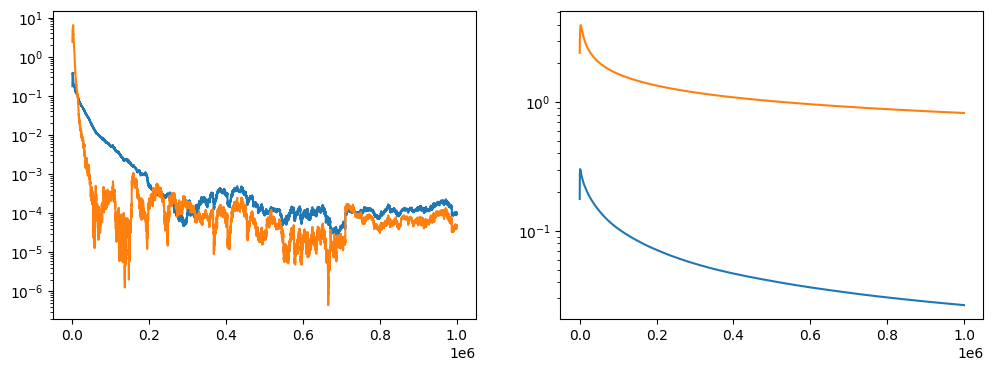

In [45]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(ns, errors_sgd);
ax[0].plot(ns, errors_smd);
ax[0].set_yscale('log')

ax[1].plot(ns, errors_sgd_bar);
ax[1].plot(ns, errors_smd_bar);
ax[1].set_yscale('log')

In [54]:
y_sgd_s[-1]/sum(y_sgd_s[-1])

array([0.24316013, 0.40984939, 0.34699048])

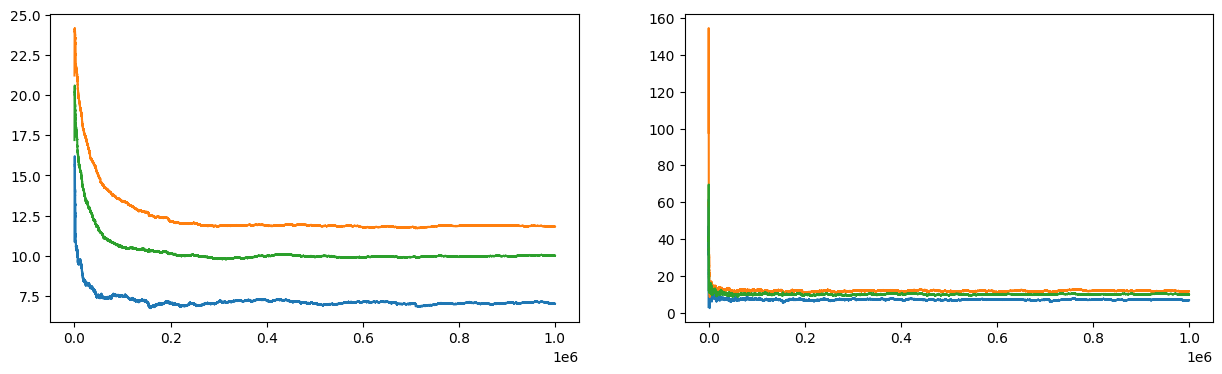

In [44]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].plot(y_sgd_s);
ax[1].plot(y_smd_s);

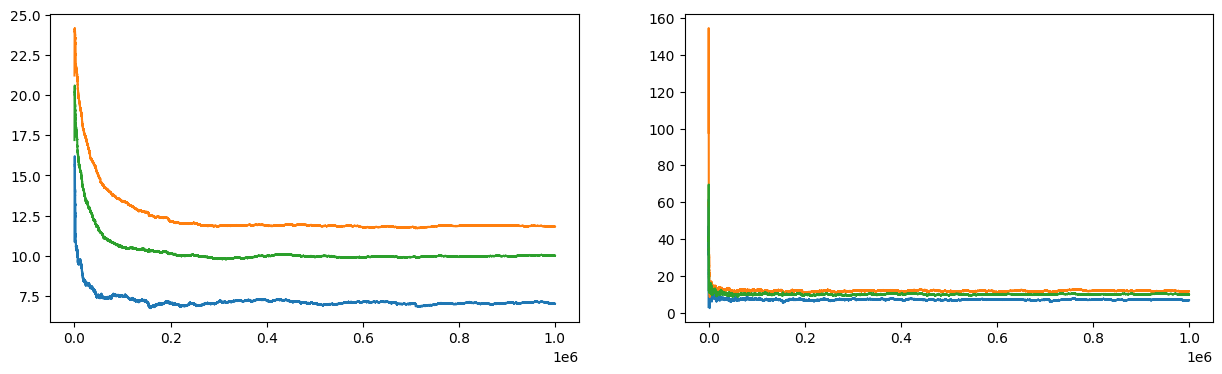

In [42]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].plot(y_sgd_s);
ax[1].plot(y_smd_s);

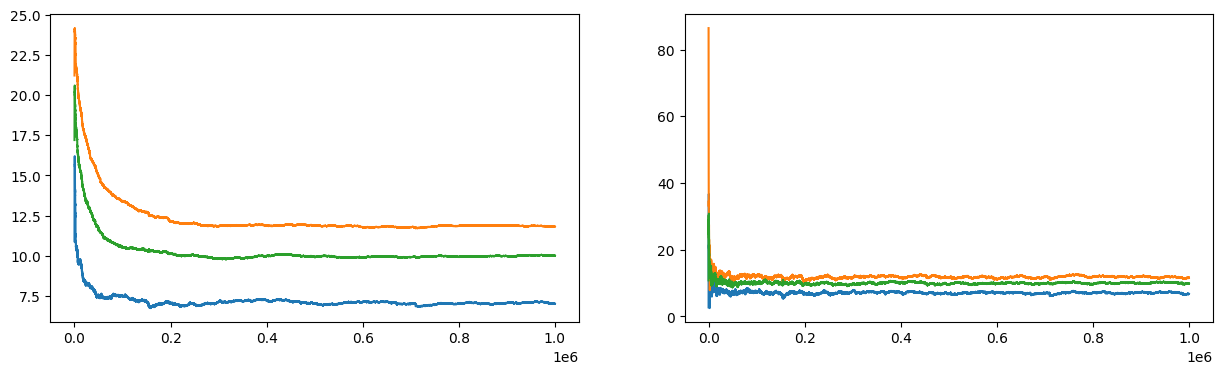

In [36]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].plot(y_sgd_s);
ax[1].plot(y_smd_s);


In [37]:
y_sgd_s[-1]

array([ 7.00890287, 11.81359223, 10.00173283])

In [38]:
y_smd_s[-1]

array([ 6.75119649, 11.65253988,  9.8515459 ])

==== True Risk Budgeting portfolio ====
[0.2458 0.4095 0.3447]
==== Risk Budgeting portfolio from SGD ====
[0.2442 0.4098 0.346 ]
CPU times: total: 34.5 s
Wall time: 35.1 s


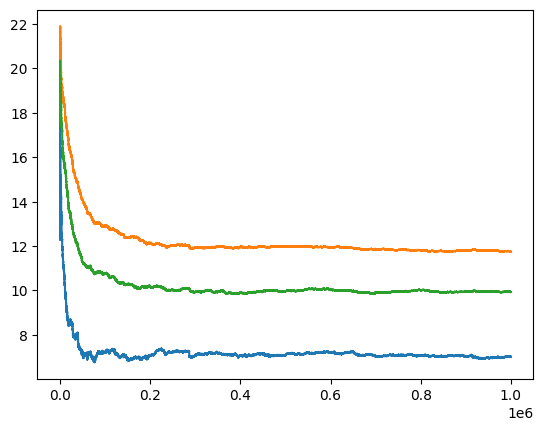

In [10]:
%%time
# we define our risk budgeting problem for expected shortfall
rb = RiskBudgeting(risk_measure='expected_shortfall',
                   alpha=0.95,
                   budgets='ERC')
rb.solve(X, 
         epochs=1,
         minibatch_size=1,
         eta_0_y=10, 
         eta_0_t=10,
         c=0.65,
         polyak_ruppert=0.2,
         store=True)

print('==== True Risk Budgeting portfolio ====')
print(np.round(SM_theta, 4))
print('==== Risk Budgeting portfolio from SGD ====')
print(np.round(rb.x, 4))

plt.plot(rb.ys);

In [27]:
%%time
M=30
rb_md = stoch_sol(X, M, n_val, nb_asset, budgets, n_epochs=1, gamma=10)

100%|██████████| 1/1 [00:43<00:00, 43.86s/it]

CPU times: total: 43 s
Wall time: 43.9 s


#### Error analysis

In [23]:
y_s = np.array(rb.ys)
x,y,z = np.array(rb_md.y_bars).shape
y_s_md = np.array(rb_md.y_bars).reshape(x,z)
optimal_loss = StudentMixtureExpectedShortfall(SM_model).expected_shortfall(optim_res.x, alpha) - np.dot(budgets, np.log(optim_res.x))
optimal_loss

-1.2280854838694133

In [24]:
errors = []
errors_md = []
for i in tqdm(range(0,len(y_s)-1,100)):
    errors.append(StudentMixtureExpectedShortfall(SM_model).expected_shortfall(y_s[i], alpha) - np.dot(budgets, np.log(y_s[i])) - optimal_loss)
    errors_md.append(StudentMixtureExpectedShortfall(SM_model).expected_shortfall(y_s_md[i], alpha) - np.dot(budgets, np.log(y_s_md[i])) - optimal_loss)

100%|██████████| 10000/10000 [00:43<00:00, 232.36it/s]


In [51]:
len(y_s)

1000001

In [52]:
len(y_s_md)

1000000

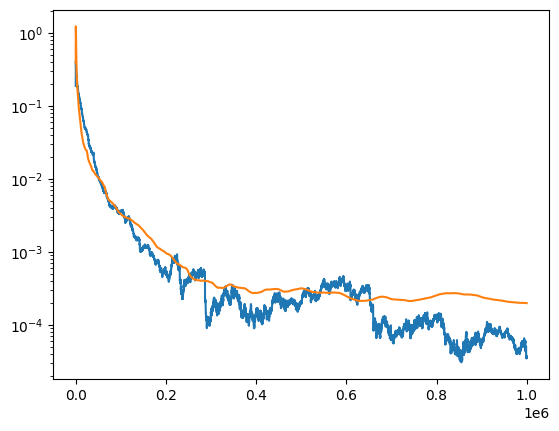

In [25]:
plt.plot(range(0,len(y_s)-1,100), errors)
plt.plot(range(0,len(y_s)-1,100), errors_md)
plt.yscale('log')

In [46]:
min(errors)

1.9125464545410864e-08

In [37]:
y_s

array([[12.28042621, 19.61747494, 17.56669541],
       [13.63759952, 20.46705761, 18.51546047],
       [14.41642709, 20.9860056 , 19.08910748],
       ...,
       [ 7.05348165, 11.64680376,  9.9984121 ],
       [ 7.05377912, 11.64698391,  9.99862196],
       [ 7.05407658, 11.64716406,  9.99883181]])

In [23]:
%%time
M=50
solution_md = stoch_sol(X, M, n_val, nb_asset, budgets, n_epochs=1)

100%|██████████| 1/1 [00:26<00:00, 26.40s/it]

CPU times: total: 25.8 s
Wall time: 26.4 s


In [26]:
y_s_md = solution_md.ys.T

In [28]:
errors_md = []
for i in tqdm(range(0,len(y_s_md),50)):
    errors_md.append(StudentMixtureExpectedShortfall(SM_model).expected_shortfall(y_s_md[i], alpha) - np.dot(budgets, np.log(y_s_md[i])) - optimal_loss)
    

100%|██████████| 20000/20000 [00:41<00:00, 482.90it/s]


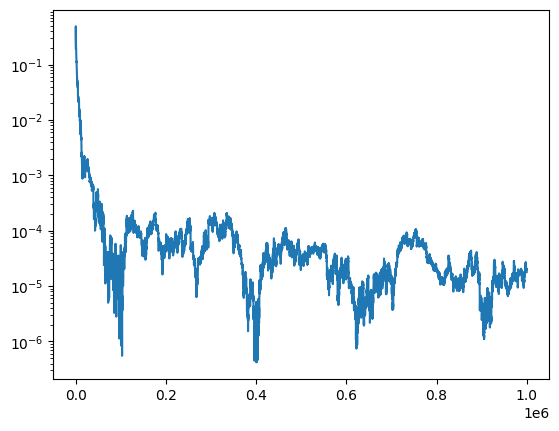

In [31]:
plt.plot(range(0,len(y_s_md),50), errors_md)
plt.yscale('log')